c:\Users\Lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kuzeyerkoc21 (kuzey). Use `wandb login --relogin` to force relogin


Loss: 0.007499463856220245
Accuracy: %99.25
--------------------------
Loss: 0.008080079220235348
Accuracy: %99.19
--------------------------
Loss: 0.00786709412932396
Accuracy: %99.21
--------------------------
Loss: 0.009496374987065792
Accuracy: %99.05
--------------------------
Loss: 0.00813205260783434
Accuracy: %99.19
--------------------------
Loss: 0.007711069658398628
Accuracy: %99.23
--------------------------
Loss: 0.009080247022211552
Accuracy: %99.09
--------------------------
Loss: 0.007876492105424404
Accuracy: %99.21
--------------------------
Loss: 0.011484606191515923
Accuracy: %98.85
--------------------------
Loss: 0.009405650198459625
Accuracy: %99.06
--------------------------
Loss: 0.009291778318583965
Accuracy: %99.07
--------------------------
Loss: 0.008229891769587994
Accuracy: %99.18
--------------------------
Loss: 0.018297769129276276
Accuracy: %98.17
--------------------------
Loss: 0.011634426191449165
Accuracy: %98.84
--------------------------
Loss: 0.

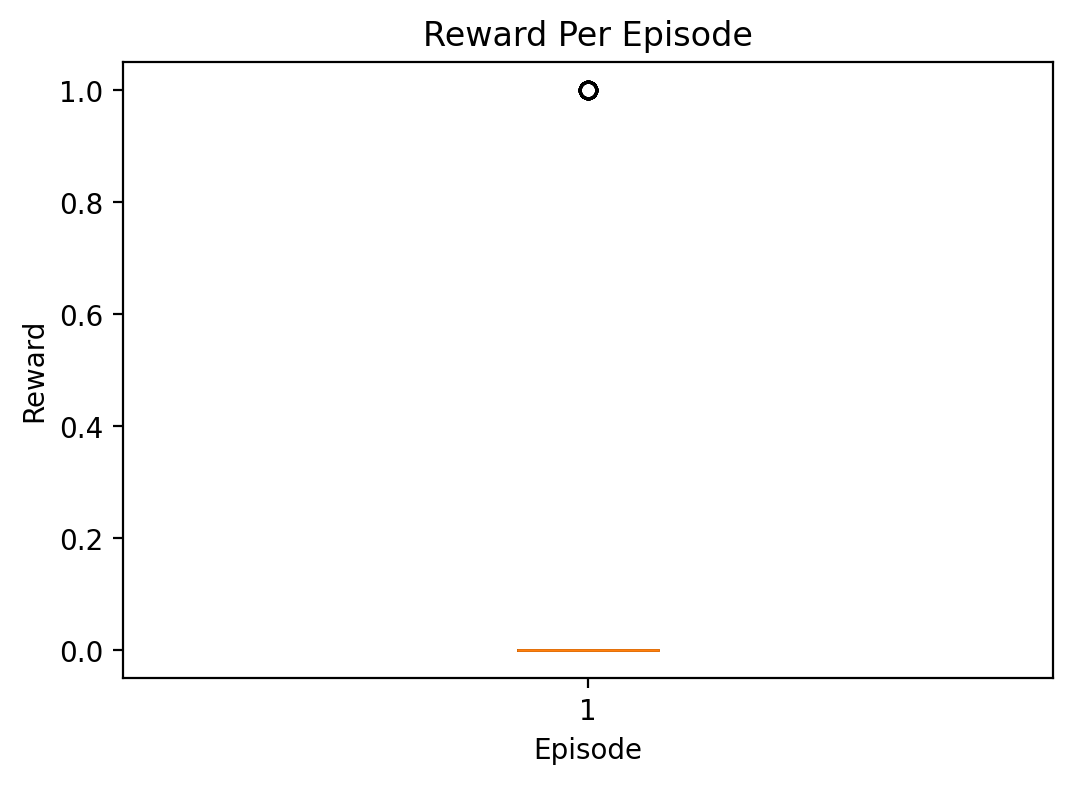

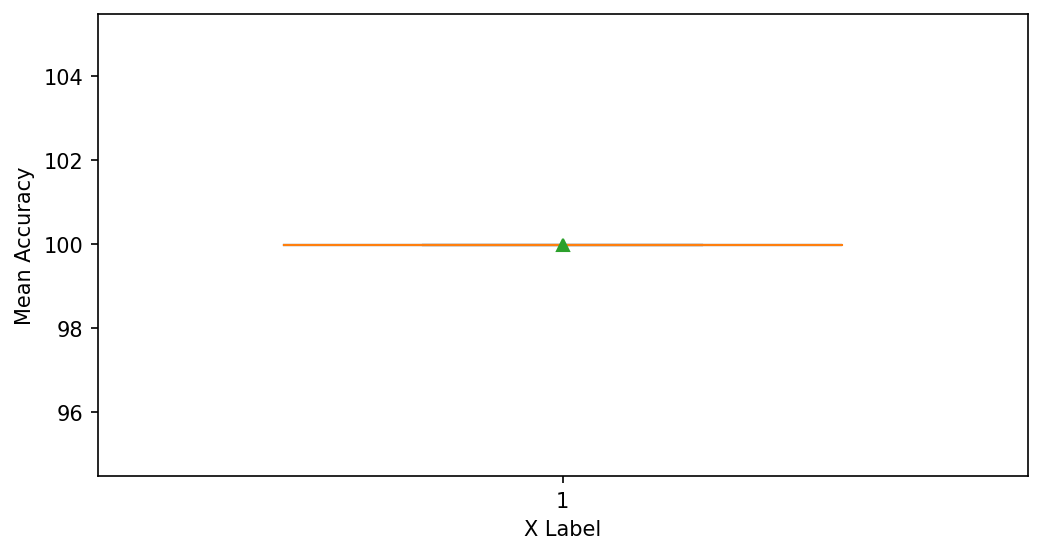

<Figure size 640x480 with 0 Axes>

In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.animation as animation
from statistics import variance
from PIL import Image
import os
import imageio
import wandb

class DeepQLearningNetwork(nn.Module):
    def __init__(self, input_state, hidden_layer, output_state):
        super().__init__()
        self.first_layer = nn.Linear(input_state, hidden_layer)  
        self.last_layer = nn.Linear(hidden_layer, output_state) 

    def forward(self, x):
        x = F.relu(self.first_layer(x))
        x = self.last_layer(x)        
        return x

class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)
    
    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

class DeepQLearning():
    BATCH_SIZE = 32 
    BUFFER_SIZE = 1000 
    LR = 0.001
    DISCOUNT = 0.9    
    SYNC_STEPS = 10 
    loss_function = nn.MSELoss() 
    optimizer = None
    actions = ["Left", "Down", "Right", "Up"]

    wandb.init(project="frozen_lake_project", config={"BATCH_SIZE": BATCH_SIZE, "LR": LR, "DISCOUNT": DISCOUNT, 
                                                    "SYNC_STEPS": SYNC_STEPS})

    def train(self, episodes, is_slippery=False):
        
        env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=is_slippery, render_mode="human")
        number_of_states = env.observation_space.n
        number_of_actions = env.action_space.n
        
        EPS = 1 
        memory = ReplayMemory(self.BUFFER_SIZE)

        policy_dqn = DeepQLearningNetwork(number_of_states, number_of_states, number_of_actions)
        target_dqn = DeepQLearningNetwork(number_of_states, number_of_states, number_of_actions)

        target_dqn.load_state_dict(policy_dqn.state_dict())

        self.optimizer = torch.optim.SGD(policy_dqn.parameters(), lr=self.LR)

        global rewards_per_episode
        rewards_per_episode = np.zeros(episodes)

        epsilon_history = []

        step_count=0
            
        for i in range(episodes):
            state = env.reset()[0]
            terminated = False     
            truncated = False    

            while(not terminated and not truncated):

                if random.random() < EPS:
                    action = env.action_space.sample() 
                else:
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_tensor_represantation(state, number_of_states)).argmax().item()

                new_state, reward, terminated, truncated, _ = env.step(action)
                memory.append((state, action, new_state, reward, terminated))
                state = new_state
                step_count += 1

            if reward == 1:
                rewards_per_episode[i] = 1

            if len(memory) > self.BATCH_SIZE and np.sum(rewards_per_episode) > 0:
                mini_batch = memory.sample(self.BATCH_SIZE)
                self.optimize(mini_batch, policy_dqn, target_dqn)   

                EPS = max(EPS - 1 / episodes, 0)
                epsilon_history.append(EPS)

                if step_count > self.SYNC_STEPS:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count = 0

        env.close()

        torch.save(policy_dqn.state_dict(), "best_model.pt")
        print(f"Reward{rewards_per_episode}")

        try:
            reward_is_1 = rewards_per_episode.tolist().index(1)
            print(f"First episode where the reward equals 1 is the {reward_is_1 + 1}th episode.")

            total_reward_is_1 = [reward for reward, x in enumerate(rewards_per_episode) if x == 1]
            print(f"Training size is {train_episode_count} and the reward could be reached in {len(total_reward_is_1)} of them.")

            print(f"The training is {len(total_reward_is_1)} / {train_episode_count} succesful.")
            
            plt.figure(dpi=200, figsize=(6, 4))
            plt.title("Reward Per Episode")
            plt.xlabel("Episode")
            plt.ylabel("Reward")
            plt.boxplot(rewards_per_episode)
            

        except ValueError:
            pass

        sum_rewards = np.zeros(episodes)

        
    def optimize(self, mini_batch, policy_dqn, target_dqn):

        number_of_states = policy_dqn.first_layer.in_features

        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:

            if terminated: 
                target = torch.FloatTensor([reward])
            else:
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.DISCOUNT * target_dqn(self.state_to_tensor_represantation(new_state, number_of_states)).max())

            current_q = policy_dqn(self.state_to_tensor_represantation(state, number_of_states))
            current_q_list.append(current_q)

            target_q = target_dqn(self.state_to_tensor_represantation(state, number_of_states)) 
            target_q[action] = target
            target_q_list.append(target_q)

        loss = self.loss_function(torch.stack(current_q_list), torch.stack(target_q_list))
        
        global accuracy
        accuracy = (1-loss) * 100

        print(f"Loss: {loss}")
        print(f"Accuracy: %{accuracy:.2f}")
        print("--------------------------")        

        wandb.log({"Loss": loss, "Accuracy": accuracy, "Reward": rewards_per_episode})

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def state_to_tensor_represantation(self, state:int, number_of_states:int):
        input_tensor = torch.zeros(number_of_states)
        input_tensor[state] = 1
        return input_tensor

    def test(self, episodes, is_slippery=False):
        
        env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=is_slippery, render_mode="rgb_array")
        number_of_states = env.observation_space.n
        number_of_actions = env.action_space.n

        policy_dqn = DeepQLearningNetwork(number_of_states, number_of_states, number_of_actions) 
        policy_dqn.load_state_dict(torch.load("best_model.pt"))
        policy_dqn.eval()  

        for i in range(episodes):
            state = env.reset()[0]  
            terminated = False    
            truncated = False                

            while(not terminated and not truncated):  
                with torch.no_grad():
                    action = policy_dqn(self.state_to_tensor_represantation(state, number_of_states)).argmax().item()

                state, reward, terminated, truncated, _ = env.step(action)

        env.close()

    def box_whisker_plot(self, var):
        plt.figure(figsize=(8, 4), dpi=150)
        plt.xlabel("X Label")
        plt.ylabel("Mean Accuracy")
        plt.boxplot(x=var.detach().numpy().reshape(1), widths=0.6, showmeans=True)
        plt.show()
        plt.savefig("graphs/box_whiskers_plot_accuracy.png")


model = DeepQLearning()
train_episode_count = 1000
test_episode_count = 10

model.train(train_episode_count, is_slippery=False)
model.test(test_episode_count, is_slippery=False)
model.box_whisker_plot(accuracy)